In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Introduction to CASA tools

This tutorial is meant to provide an introduction to working with the `tb` and `ms` tools of CASA.

## Introduction to measurement sets
Before you begin, it's worthwhile reviewing the CASA documentation on the measurement set, which is the default storage format for radio interferometric observations. The basics are [here](https://casa.nrao.edu/casadocs-devel/stable/casa-fundamentals/the-measurementset) and the description of the v2 format is [here](https://casa.nrao.edu/casadocs-devel/stable/casa-fundamentals/measurement-set). To make a long story short, a measurement set (e.g., ``my_ALMA_data.ms``) is a folder containing a set of binary 'tables' with your data and metadata. The contents within this measurement set folder serve as a [relational database](https://en.wikipedia.org/wiki/Relational_database). It helps to keep this structure in mind as we navigate its contents.

A good first task is to load up an interactive prompt of CASA and run [listobs](https://casa.nrao.edu/casadocs-devel/stable/global-task-list/task_listobs/about) to familiarize yourself with the basic structure of your measurement set. It will be very helpful to know things like how many spectral windows there are, how many execution blocks there are, and what targets were observed. Hopefully you've already [split](https://casa.nrao.edu/casadocs-devel/stable/calibration-and-visibility-data/uv-manipulation/splitting-out-calibrated-uv-data-split) out your data such that it only contains the target under consideration and does not include any extra calibrator targets. It's also a good idea to inspect and plot the visibilities of your measurement set using CASA's [plotms](https://casa.nrao.edu/casadocs-devel/stable/calibration-and-visibility-data/data-examination-and-editing/using-plotms-to-plot-and-edit-visibilities-and-calibration-tables) tool.

CASA provides the [casabrowser/browsetable](https://casa.nrao.edu/casadocs-devel/stable/calibration-and-visibility-data/data-examination-and-editing/browse-a-table) tool, which is very handy for graphically exploring the structure and contents of this relational database. If something about the structure of the measurement set doesn't make sense, it's usually a good idea to open up *browsetable* and dig into the structure of the individual tables.

## CASA tools
CASA provides a set of lower-level "tools" for direct interaction with the measurement set contents. The full API list is available [here](https://casa.nrao.edu/casadocs-devel/stable/global-tool-list).

To experiment with reading and plotting visibilities, we'll use a measurement set that we prepared using simobserve. The full commands to generate the measurement set are available via the `mpoldatasets` package [here](https://github.com/MPoL-dev/mpoldatasets/blob/main/products/ALMA-logo/simobserve_cube.py).

You can access the CASA tools from within your Python environment if you've successfully installed ``casatools`` package as part of the [modular CASA install](https://casa.nrao.edu/casadocs-devel/stable/usingcasa/obtaining-and-installing), as shown here. If you are unable to install the modular package, you can always use the [casatools directly inside of the monolithic CASA intepreter](https://casa.nrao.edu/casadocs-devel/stable/casa-fundamentals/tasks-and-tools). If you're working directly within the CASA interpreter, you can skip this section and move directly to the example queries.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
import tempfile
import tarfile
import os

In [4]:
# load the mock dataset of the ALMA logo
fname_tar = download_file(
    "https://zenodo.org/record/4711811/files/logo_cube.noise.ms.tar.gz",
    cache=True,
    show_progress=True,
    pkgname="mpol",
)

In [5]:
# extract the measurement set to a local directory
temp_dir = tempfile.TemporaryDirectory()
curdir = os.getcwd()
os.chdir(temp_dir.name)

In [6]:
with tarfile.open(fname_tar) as tar:
    tar.extractall()

Now we've successfully downloaded and extracted the measurement set

In [7]:
!ls 

logo_cube.noise.ms


In [8]:
fname = "logo_cube.noise.ms"

If you're working with your own measurement set, you can start directly from here.

Let's import and then instantiate the relevant CASA tools, [table](https://casa.nrao.edu/casadocs-devel/stable/global-tool-list/tool_table/methods) and [ms](https://casa.nrao.edu/casadocs-devel/stable/global-tool-list/tool_ms/methods).

In [9]:
import casatools

In [10]:
tb = casatools.table()
ms = casatools.ms()

## Example Queries with table tools
The following are some examples of simple queries you might like to do for a simply structured measurement set using the `tb` tool. If they don't work, you might look using the `ms` tool, described at the bottom of the page.

### Unique spectral window IDs
Get the indexes of the unique spectral windows, typically indexed by the ``DATA_DESC_ID``

In [11]:
tb.open(fname)
spw_id = tb.getcol("DATA_DESC_ID")  # array of int with shape [npol, nchan, nvis]
tb.close()
print(np.unique(spw_id))

[0]


``DATA_DESC_ID`` might not always be a perfect stand-in for ``SPECTRAL_WINDOW_ID``, see the [data description table](https://casa.nrao.edu/casadocs-devel/stable/casa-fundamentals/measurement-set) for more information. You could also try accessing the ``DATA_DESCRIPTION`` table directly by providing it as a subdirectory to the main table like so

In [12]:
tb.open(fname + "/DATA_DESCRIPTION")
SPECTRAL_WINDOW_ID = tb.getcol("SPECTRAL_WINDOW_ID")
tb.close()
print(SPECTRAL_WINDOW_ID)

[0]


### Column names of main table
Open the main table of the measurement set and inspect the column names

In [13]:
tb.open(fname)
colnames = tb.colnames()
tb.close()
print(colnames)

['UVW', 'FLAG', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'MODEL_DATA', 'CORRECTED_DATA']


### How many channels in each spw
Let's figure out how many channels there are, and what their frequencies are (in Hz)

In [14]:
tb.open(fname + "/SPECTRAL_WINDOW")
num_chan = tb.getcol("NUM_CHAN")
chan_freq = tb.getcol("CHAN_FREQ")
tb.close()
print(num_chan)
print(chan_freq)

[9]
[[2.30523958e+11]
 [2.30524112e+11]
 [2.30524266e+11]
 [2.30524420e+11]
 [2.30524573e+11]
 [2.30524727e+11]
 [2.30524881e+11]
 [2.30525035e+11]
 [2.30525189e+11]]


### Get the baselines
Read the baselines (in units of [m])

In [15]:
tb.open(fname)
uvw = tb.getcol("UVW")  # array of float64 with shape [3, nvis]
tb.close()
uu, vv, ww = uvw  # unpack into len nvis vectors

We can plot these up easily

Text(0, 0.5, '$v$ [m]')

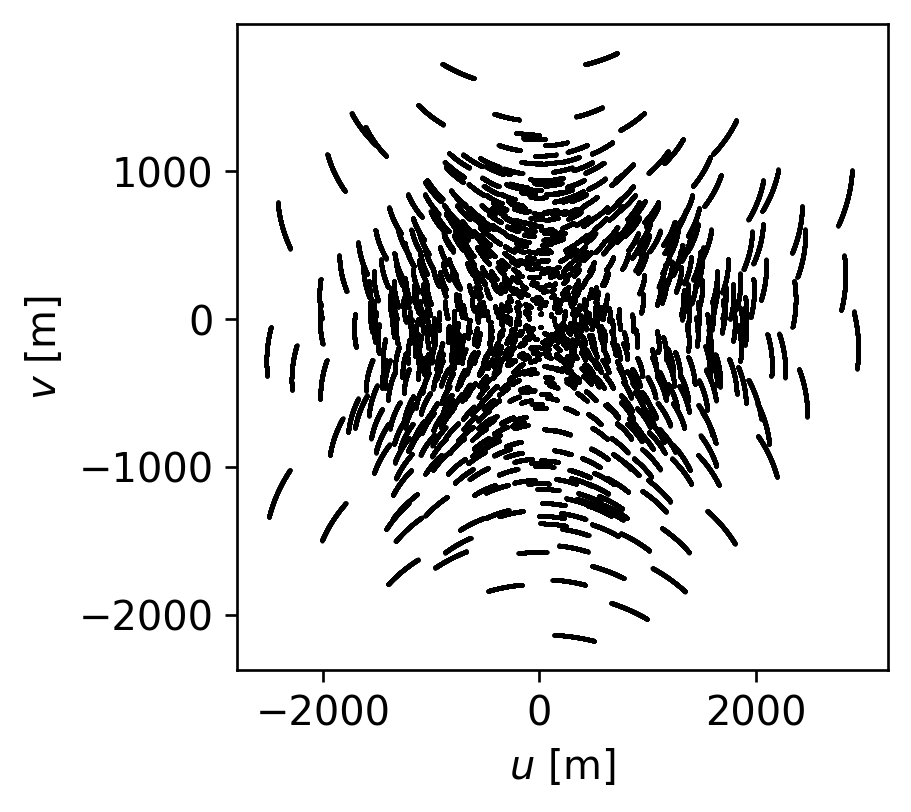

In [16]:
fig, ax = plt.subplots(nrows=1, figsize=(3.5, 3.5))
ax.scatter(uu, vv, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [m]")
ax.set_ylabel(r"$v$ [m]")

### Convert baselines to units of kilolambda
To convert the baselines to units of kilolambda, we need to know the observing frequency (or wavelength). For a spectral window with multiple channels (like this one), the baselines (if expressed in units of kilolambda) will be slightly different for each channel because the observing frequency is different for each channel. Here is one way to go about broadcasting the baselines to all channels and then converting them to units of kilolambda.

In [17]:
tb.open(fname)
uvw = tb.getcol("UVW")  # array of float64 with shape [3, nvis]
tb.close()

True

In [18]:
tb.open(fname + "/SPECTRAL_WINDOW")
num_chan = tb.getcol("NUM_CHAN")
chan_freq = tb.getcol("CHAN_FREQ")
tb.close()

True

In [19]:
uu, vv, ww = uvw  # unpack into len nvis vectors

In [20]:
# broadcast to the same shape as the data
# stub to broadcast uu,vv, and weights to all channels
nchan = num_chan[0]  # grab the number of channels for the first spectral window
broadcast = np.ones((nchan, 1))
uu = uu * broadcast
vv = vv * broadcast

In [21]:
# calculate wavelengths in meters
c_ms = 2.99792458e8  # [m s^-1]
wavelengths = c_ms / chan_freq[:, np.newaxis]  # m

In [22]:
# convert baselines to klambda
uu = 1e-3 * uu / wavelengths  # [klambda]
vv = 1e-3 * vv / wavelengths  # [klambda]

Let's plot up the baseline coverage for the first channel of the cube (index `0`).

Text(0, 0.5, '$v$ [k$\\lambda$]')

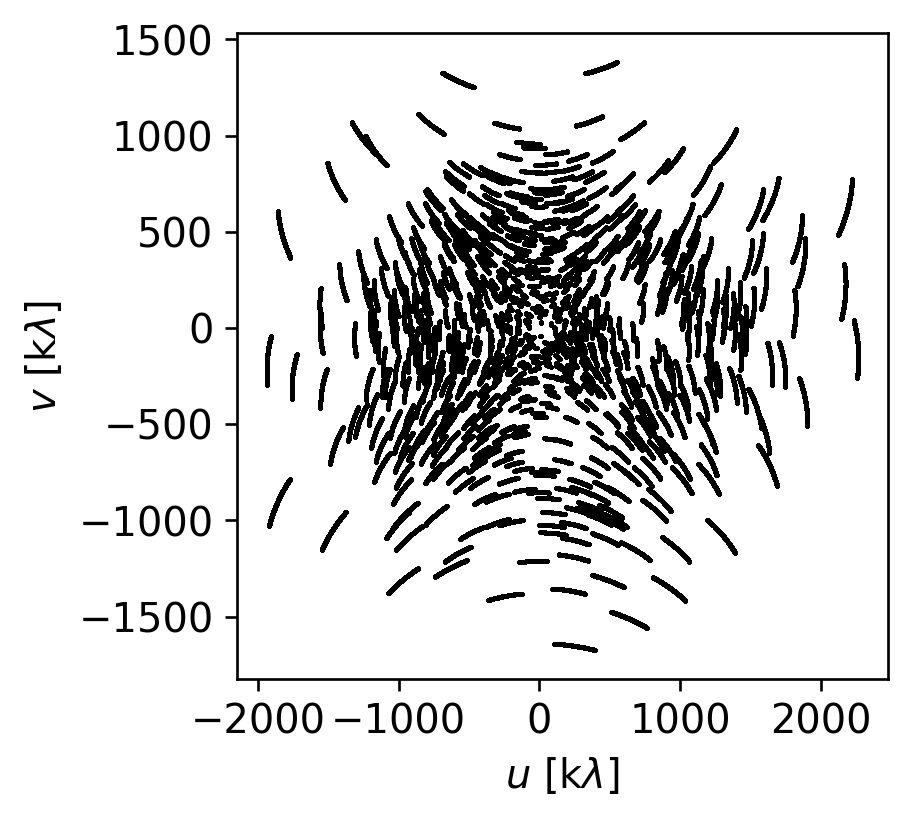

In [23]:
fig, ax = plt.subplots(nrows=1, figsize=(3.5, 3.5))
ax.scatter(uu[0], vv[0], s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")

### Read the visibility values and inspect flags
Visibilities are stored in the main table of the measurement set. As long as all spectral windows have the same number of channels and polarizations, it should be possible to read visibilities using the table tool. If not, try the `ms` tool.

In [24]:
tb.open(fname)
weight = tb.getcol("WEIGHT")  # array of float64 with shape [npol, nvis]
flag = tb.getcol("FLAG")  # array of bool with shape [npol, nchan, nvis]
data_raw = tb.getcol("DATA")  # array of complex128 with shape [npol, nchan, nvis]
data_corrected = tb.getcol(
    "CORRECTED_DATA"
)  # array of complex128 with shape [npol, nchan, nvis]
tb.close()

True

Depending on how you've calibrated and/or split out your data, your measurement set may or may not have a ``CORRECTED_DATA`` column. Usually, this is the one you want. If the column doesn't exist in your measurement set, try the ``DATA`` column instead.

For each visibility $i$ there is also an accompanying ``WEIGHT`` $w_i$, which should correspond to the statistical uncertainty on the real and imaginary component of each visibility. Formally, the weight is defined as

$$
w_i = \frac{1}{\sigma_i^2}
$$

and we expect that the noise is independent for each of the real and imaginary components of a visibility measurement. This means that we expect

$$
\Re \{V_i\} = \Re\{\mathcal{V}\}_i + \epsilon_1
$$

and

$$
\Im \{V_i\} = \Im\{\mathcal{V}\}_i + \epsilon_2
$$

where for each real and each imaginary component $\epsilon$ is a new noise realization from a mean-zero Gaussian with standard deviation $\sigma_i$, i.e.,

$$
\epsilon \sim \mathcal{N}\left ( 0, \sigma_i \right )
$$

CASA has a [history](https://casa.nrao.edu/casadocs-devel/stable/calibration-and-visibility-data/data-weights) of different weight definitions, so this is definitely an important column to pay attention to, especially if your data was not acquired and processed in very recent cycles.

A common ALMA observation mode is dual-polarization, XX and YY. If this is the case for your observations, the data array will contain an extra dimension for each polarization.

In [25]:
print(data_corrected.shape)

(2, 9, 325080)


Since it has a complex type, the data array contains the real and imaginary values

In [26]:
print(data_corrected.real)
print(data_corrected.imag)

[[[-2.11916161 -0.15268645 -2.09786391 ... -2.13404036 -2.90118766
   -1.04123235]
  [ 1.53342223 -0.23143989  2.98143935 ... -0.94676274  2.0068481
   -0.11907034]
  [-0.79662246 -1.14639163  0.62018895 ...  0.24236043  0.29283872
    0.59977692]
  ...
  [-3.14505744  0.23288387 -1.28614867 ... -0.72165859 -1.80558801
    0.67348379]
  [ 1.32995152 -0.82827419  1.19441712 ...  2.12295151  0.56704634
    1.1603682 ]
  [ 1.44905758 -2.0859952   0.92960811 ...  0.80752301  1.82628858
   -0.09598707]]

 [[-0.03108021  3.73795938  2.53667879 ...  5.75586653  0.0541618
    0.34355548]
  [ 3.1469512   0.71387434  3.32055974 ...  0.3358534   0.84201574
   -3.85533071]
  [ 1.29277086  2.72364378 -0.55683601 ...  0.10498993 -2.5439899
   -0.55325317]
  ...
  [ 0.3654843   3.06427026 -0.3840104  ...  0.46281165  0.90841991
    0.15608166]
  [ 2.74898171  3.61377883  1.09398103 ...  1.70834064  0.86575133
   -0.79096657]
  [ 1.91854882 -1.39442146  1.24067175 ...  1.52981687  0.09519701
    0.036

In the process of calibrating real-world data, some occasional visibilities need to be flagged or excluded from the analysis. The ``FLAG`` column is a boolean flag that is ``True`` if the visibility *should be excluded*. To check if any visibilities are flagged in this spectral window, we can just see if there are any ``True`` values in the ``FLAG`` column

In [27]:
print("Are there any flagged visibilities?", np.any(flag))

Are there any flagged visibilities? False


Since this is a simulated measurement set, this is not surprising. When you are using real data, however, this is an important thing to check. If you *did* have flagged visibilities, to access only the valid visibilities you would do something like the following

In [28]:
data_good = data_corrected[~flag]

where the ``~`` operator helps us index only the visibilities which *are not flagged*. Unfortunately, indexing en masse like this removes any polarization and channelization dimensionality, just giving you a flat list

In [29]:
print(data_good.shape)

(5851440,)


so you'll need to be more strategic about this if you'd like to preserve the channel dimensions, perhaps by using a masked array or a ragged list.

### Read visibility values and averaging polarizations
If your dataset is dual-polarization but you are not interested in treating the polarizations separately, it might be worth it to average the polarization channels together.

In [30]:
tb.open(fname)
uvw = tb.getcol("UVW")  # array of float64 with shape [3, nvis]
weight = tb.getcol("WEIGHT")  # array of float64 with shape [npol, nvis]
flag = tb.getcol("FLAG")  # array of bool with shape [npol, nchan, nvis]
data = tb.getcol("CORRECTED_DATA")  # array of complex128 with shape [npol, nchan, nvis]
tb.close()

True

In [31]:
# average the polarizations
# https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
data = np.sum(data * weight[:, np.newaxis, :], axis=0) / np.sum(weight, axis=0)

In [32]:
# flag the data if either polarization was flagged
flag = np.any(flag, axis=0)

In [33]:
# combine the weights across polarizations
weight = np.sum(weight, axis=0)

In [34]:
# Calculate the "radial" baseline
uu, vv, ww = uvw
qq = np.sqrt(uu ** 2 + vv ** 2)

In [35]:
# calculate visibility amplitude and phase
amp = np.abs(data)
phase = np.angle(data)

Text(0, 0.5, 'Amplitude [Jy]')

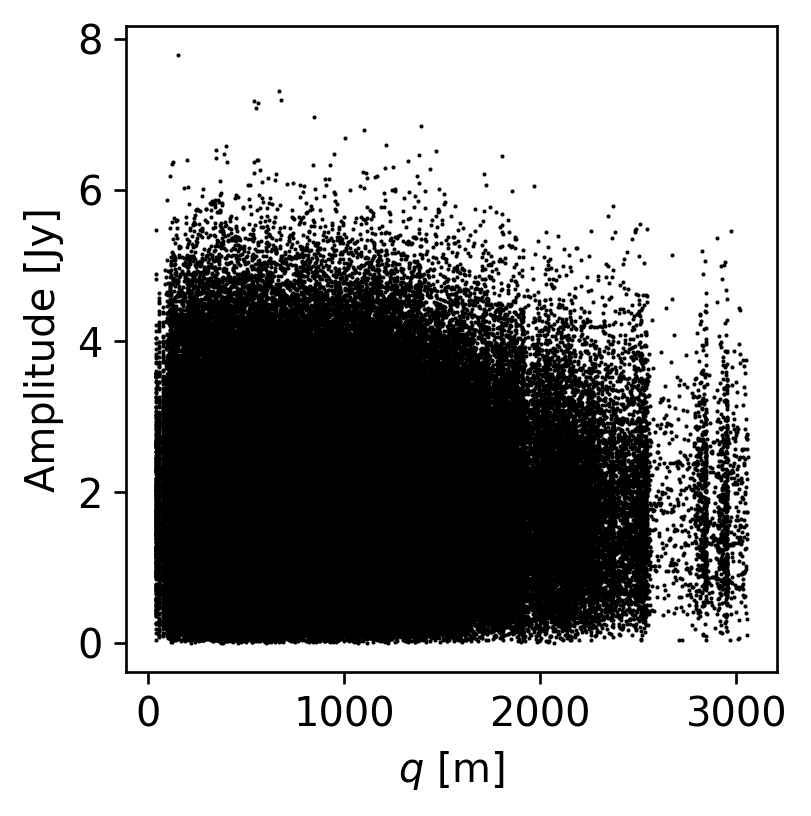

In [36]:
# Let's plot up the visibilities for the first channel
fig, ax = plt.subplots(nrows=1, figsize=(3.5, 3.5))
ax.scatter(qq, amp[0], s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$q$ [m]")
ax.set_ylabel(r"Amplitude [Jy]")

## Example Queries with ms tools
Sometimes your measurement set might contain multiple spectral windows with different numbers of channels or polarizations. In such a situation, the above queries with the ``tb`` tool will most likely fail, because they are trying to read data with inherently different shapes into an array with one common shape. One solution is to use the [ms](https://casa.nrao.edu/casadocs-devel/stable/global-tool-list/tool_ms/methods) tool.

The two most useful methods are ``ms.selectinit`` followed by ``ms.getdata``. The first earmarks a subset of data based upon the given ``DATA_DESC_ID``, the second returns the actual data. It is possible to retrieve the data from a single spectral window because all data within a given spectral window will have the same polarization and channelization setup. The downside is that if your dataset has multiple spectral windows, you will need to repeat the queries for each one. It isn't obvious that there is a faster way to retrieve the data in such a situation, however.

In [37]:
ms.open(fname)
# select the spectral window
ms.selectinit(datadescid=0)
# query the desired columnames as a list
query = ms.getdata(["WEIGHT", "UVW"])
# always a good idea to reset the earmarked data
ms.selectinit(reset=True)
ms.close()

True

In [38]:
# The returned query is a dictionary whose
# keys are the lowercase column names
print(query)

{'uvw': array([[  105.98776896,    10.24073444,   -67.90482364, ...,
         2887.05933484,  1535.13378272, -1351.92555212],
       [   20.59023049,    36.16467912,   -58.30157267, ...,
         1007.13306603,  -340.05445448, -1347.18752051],
       [   47.86746886,    51.8762483 ,   -86.58515203, ...,
          730.95064349,  -862.07174858, -1593.02239207]]), 'weight': array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])}


In [39]:
# And the data values are the same as before
uvw = query["uvw"]
print(uvw.shape)

(3, 325080)


## Putting it together to export visibilities
This slightly larger example shows how to combine some of the above queries to read channel frequencies, baselines, and visibilites, and export them from the CASA environment saved as an ``*.npz`` file.

In [40]:
# query the data
tb.open(fname)
ant1 = tb.getcol("ANTENNA1")  # array of int with shape [nvis]
ant2 = tb.getcol("ANTENNA2")  # array of int with shape [nvis]
uvw = tb.getcol("UVW")  # array of float64 with shape [3, nvis]
weight = tb.getcol("WEIGHT")  # array of float64 with shape [npol, nvis]
flag = tb.getcol("FLAG")  # array of bool with shape [npol, nchan, nvis]
data = tb.getcol("CORRECTED_DATA")  # array of complex128 with shape [npol, nchan, nvis]
tb.close()

True

In [41]:
# get the channel information
tb.open(fname + "/SPECTRAL_WINDOW")
chan_freq = tb.getcol("CHAN_FREQ")
num_chan = tb.getcol("NUM_CHAN")
tb.close()
chan_freq = chan_freq.flatten()  # Hz
nchan = len(chan_freq)

Check to make sure the channels are in blushifted to redshifted order, otherwise reverse channel order

In [42]:
if (nchan > 1) and (chan_freq[1] > chan_freq[0]):
    # reverse channels
    chan_freq = chan_freq[::-1]
    data = data[:, ::-1, :]
    flag = flag[:, ::-1, :]

Keep only the cross-correlation visibilities and throw out the auto-correlation visibilities (i.e., where ``ant1 == ant2``)

In [43]:
xc = np.where(ant1 != ant2)[0]
data = data[:, :, xc]
flag = flag[:, :, xc]
uvw = uvw[:, xc]
weight = weight[:, xc]

In [44]:
# average the polarizations
data = np.sum(data * weight[:, np.newaxis, :], axis=0) / np.sum(weight, axis=0)
flag = np.any(flag, axis=0)
weight = np.sum(weight, axis=0)

In [45]:
# After this step, ``data`` should be shape ``(nchan, nvis)`` and weights should be shape ``(nvis,)``
print(data.shape)
print(flag.shape)
print(weight.shape)

(9, 325080)
(9, 325080)
(325080,)


In [46]:
# when indexed with mask, returns valid visibilities
mask = ~flag

In [47]:
# convert uu and vv to kilolambda
uu, vv, ww = uvw  # unpack into len nvis vectors
# broadcast to the same shape as the data
# stub to broadcast uu,vv, and weights to all channels
broadcast = np.ones((nchan, 1))
uu = uu * broadcast
vv = vv * broadcast
weight = weight * broadcast

In [48]:
# calculate wavelengths in meters
wavelengths = c_ms / chan_freq[:, np.newaxis]  # m

In [49]:
# calculate baselines in klambda
uu = 1e-3 * uu / wavelengths  # [klambda]
vv = 1e-3 * vv / wavelengths  # [klambda]

In [50]:
frequencies = chan_freq * 1e-9  # [GHz]

Since we have a multi-channel dataset, we need to make a decision about how to treat flagged visibilities. If we wanted to export only unflagged visibilities, there is a chance that some channels will have different number of flagged visibilities, which means we can no longer represent the data as a nicely packed, contiguous, rectangular array.

 Here, we sidestep this issue by just exporting *all* of the data (including flagged, potentially erroneous, visibilities), but, we also include the ``mask`` used to identify the valid visibilities. This punts on a final decision about how to store unflagged visibilities---the user will need to make sure that they correctly apply the mask when they load the data in a new environment.

In [51]:
# save data to numpy file for later use
np.savez(
    "visibilities.npz",
    frequencies=frequencies,  # [GHz]
    uu=uu,  # [klambda]
    vv=vv,  # [klambda]
    weight=weight,  # [1/Jy^2]
    data=data,  # [Jy]
    mask=mask,  # [Bool]
)